In [2]:
from src.utils.inference import show_images
import time
from src.camera.image_processing import get_clean_frame, get_redness_frame
from src.camera.camera_calibration import get_master_dark
import numpy as np
from src.camera.camera_setup import setup_camera
import os
from collections import deque
from src.camera.camera_stream import CameraStream
import zwoasi as asi
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from src.fsm.fsm_setup import setup_fsm
from src.utils.io import load_results


Camera controls:
	AutoExpMaxExpMS
		ControlType: 11
		DefaultValue: 100
		Description: 'Auto exposure maximum exposure value(unit ms)'
		IsAutoSupported: False
		IsWritable: True
		MaxValue: 60000
		MinValue: 1
		Name: 'AutoExpMaxExpMS'
	AutoExpMaxGain
		ControlType: 10
		DefaultValue: 300
		Description: 'Auto exposure maximum gain value'
		IsAutoSupported: False
		IsWritable: True
		MaxValue: 600
		MinValue: 0
		Name: 'AutoExpMaxGain'
	AutoExpTargetBrightness
		ControlType: 12
		DefaultValue: 100
		Description: 'Auto exposure target brightness value'
		IsAutoSupported: False
		IsWritable: True
		MaxValue: 160
		MinValue: 50
		Name: 'AutoExpTargetBrightness'
	BandWidth
		ControlType: 6
		DefaultValue: 50
		Description: 'The total data transfer rate percentage'
		IsAutoSupported: True
		IsWritable: True
		MaxValue: 100
		MinValue: 40
		Name: 'BandWidth'
	Exposure
		ControlType: 1
		DefaultValue: 10000
		Description: 'Exposure Time(us)'
		IsAutoSupported: True
		IsWritable: True
		MaxVa

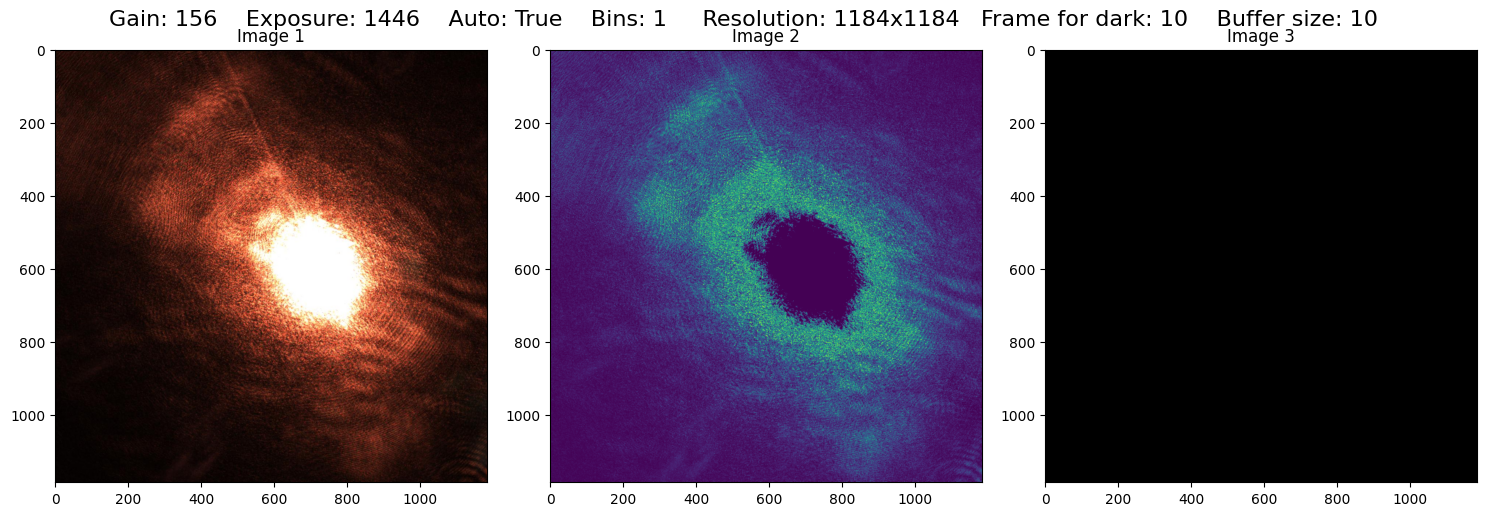

Cleaning up
Stopping camera stream thread
Camera stream thread stopped
Cleanup complete.


In [15]:
BINS = 1
# Have both gain and exposure as None to allow auto calibration
GAIN = None
EXPOSURE = None #us
roi_dim = 1184
frames_for_dark = 10
buffer_size = 10


root_dir = os.path.dirname(os.getcwd())
camera = setup_camera(root_dir, 'libASICamera2.dylib', bins=BINS, gain= GAIN, exposure= EXPOSURE, roi_dim= roi_dim)

master_dark: np.ndarray = get_master_dark(camera, num_frames= frames_for_dark)

stream = CameraStream(camera).start()
time.sleep(1)

buffer = deque(maxlen = buffer_size)

while True:
    is_start = input(f"\nStart? Y/n ")

    if is_start.lower() == "y":
        break

try:
    for _ in [10]:
        light_frame = stream.read()

        if light_frame is None:
            time.sleep(0.01)
            continue

        clean_light_frame = get_clean_frame(light_frame, master_dark)
        redness_frame = get_redness_frame(clean_light_frame)

        buffer.append(redness_frame)
    reddest_image = np.median(np.stack(buffer, axis=0), axis=0).astype(np.uint8)
    show_images("test_colour_image.jpg",
                reddest_image,
                master_dark,
                title = f"Gain: {camera.get_control_value(asi.ASI_GAIN)[0]}    "
                        f"Exposure: {camera.get_control_value(asi.ASI_EXPOSURE)[0]}    "
                        f"Auto: {GAIN is None and EXPOSURE is None}    "
                        f"Bins: {BINS}     "
                        f"Resolution: {int(roi_dim/BINS)}x{int(roi_dim/BINS)}   "
                        f"Frame for dark: {frames_for_dark}    "
                        f"Buffer size: {buffer_size}")


except KeyboardInterrupt:
    print("\nTracking stopped by user.")
finally:
    print("Cleaning up")
    stream.stop()
    camera.close()
    print("Cleanup complete.")

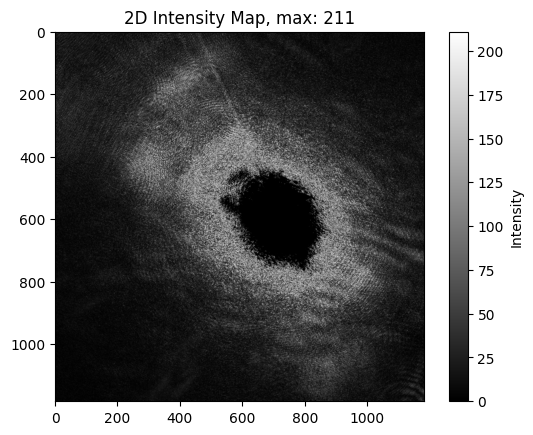

In [16]:
plt.imshow(reddest_image, cmap='gray')
plt.colorbar(label='Intensity')
plt.title(f"2D Intensity Map, max: {reddest_image.max()}")
plt.show()

In [17]:
def get_contours(image: np.ndarray) -> np.ndarray:
    _, mask = cv2.threshold(src= image,
                            thresh= 69,
                            maxval= 255,
                            type= cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_contour_origin(contour: np.ndarray) -> tuple[int, int]:
    M = cv2.moments(contour)
    largest_contour_area = M["m00"]
    assert largest_contour_area > 0; "Cannot find any contours"
    x = M["m10"] // largest_contour_area
    y = M["m01"] // largest_contour_area

    return x, y

def get_largest_contour(contour: list):
    return max(contour, key=cv2.contourArea)

contours = get_contours(reddest_image)
largest_contour = get_largest_contour(contours)
x, y = get_contour_origin(largest_contour)

original_image = np.array(Image.open(
                f"{os.path.join(os.path.dirname(os.getcwd()), 'resources', 'images')}/{'test_colour_image.jpg'}"
            ))
cv2.drawContours(
    image=original_image,
    contours=contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=largest_contour,
    center=(x, y),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

plt.imshow(largest_contour)


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [80]:
PORT: str = "/dev/cu.usbserial-249WO6MO"
BAUDRATE: int = 115200
TIMEOUT: int = 1
fsm_controller = setup_fsm(PORT, BAUDRATE, TIMEOUT)

connected to FSM on /dev/cu.usbserial-249WO6MO & write thread started
Sent: system -R
Recieved: 

= [SBOOT] System Security Check successfully passed. Starting...


=              (C) COPYRIGHT 2023 Sercalo                            =
=                                                                    =
=              Secure Boot and Secure Firmware Update                =
=              EBMM3 Rev1.1                                          =


= [SBOOT] SECURE ENGINE INITIALIZATION SUCCESSFUL
= [SBOOT] STATE: CHECK STATUS ON RESET
INFO: A Reboot has been triggered by a Software reset!
= [SBOOT] STATE: CHECK NEW FIRMWARE TO DOWNLOAD
= [SBOOT] STATE: CHECK USER FW STATUS
A FW is detected in the slot SLOT_ACTIVE_1
= [SBOOT] STATE: VERIFY USER FW SIGNATURE
= [SBOOT] STATE: EXECUTE USER FIRMWARE*************************************************************************
BEGIN BOOT SEQUENCE
LOG LEVEL: 5 (TESTING).
Driver board successfully identified
Switch to 1Wire to detect directly connec

In [63]:
fsm_controller.send_command("control -h")

Sent: control -h
Recieved: 
Manage control informations

Usage:
control [-h][-F=<FS> -f=<FORMAT>]
control strategy [-h][<STRATEGY> -a=<AXIS> -f=<FORMAT>]

Arguments:
<STRATEGY>           Control strategy to use [off|on|feedforward|pid]

Options:
-h --help            Show this screen
-F --fs=<FS>         Controller sampling frequency [Hz]
-f --format=<FORMAT> Display/Print format [raw|short|long|json|hex|csv]
-a --axis=<AXIS>     Axis selection [x|y|xy]

$


In [60]:
fsm_controller("system mems")

TypeError: 'FSMController' object is not callable

In [82]:
fsm_controller.send_command("control strategy feedforward")

Sent: control strategy feedforward
Recieved: 
Axis x: feedforward
Axis y: feedforward
$


In [253]:
fsm_controller.send_command("failsafe")


Sent: failsafe
Recieved: 
position-x status: disabled, level: 0, raised: no
position-y status: disabled, level: 0, raised: no
current-x status: enabled, level: 0.040895, raised: no
current-y status: enabled, level: 0.0308531, raised: no
overrun status: enabled, level: 0, raised: no
sensor-calibration status: disabled, level: 0, raised: no
sensor-saturation status: disabled, level: 0, raised: no
temperature status: disabled, level: 0, raised: no
timer-unavailable status: enabled, level: 0, raised: no
$


In [65]:
fsm_controller.send_command("failsafe -R")


Sent: failsafe -R
Recieved: 
position-x status: disabled, level: 0, raised: no
position-y status: disabled, level: 0, raised: no
current-x status: enabled, level: 0.0428323, raised: no
current-y status: enabled, level: 0.0346888, raised: no
overrun status: enabled, level: 0, raised: no
sensor-calibration status: disabled, level: 0, raised: no
sensor-saturation status: disabled, level: 0, raised: no
temperature status: disabled, level: 0, raised: no
timer-unavailable status: enabled, level: 0, raised: no
$


In [81]:
fsm_controller.send_command("signal input --source=waveform --axis=xy")

Sent: signal input --source=waveform --axis=xy
Recieved: 
reference values source x: waveform
reference values source y: waveform
$


In [85]:
xy: str = "y"
angle: float = 0.2
fsm_controller.send_command(f"signal generate -a {xy} -w dc -A {angle}")

Sent: signal generate -a y -w dc -A 0.2
Recieved: 
ampy = 0, freqy = 1, phasey = 0, offsety=0.2
$


In [37]:
xy: str = "x"
angle: float = 1.5
fsm_controller.send_command(f"signal generate -a {xy} -w dc -A {angle}", receive= False)
xy: str = "x"
angle: float = -1.5
fsm_controller.send_command(f"signal generate -a {xy} -w dc -A {angle}", receive= False)
xy: str = "y"
angle: float = 1.5
fsm_controller.send_command(f"signal generate -a {xy} -w dc -A {angle}", receive= False)
xy: str = "y"
angle: float = -1.5
fsm_controller.send_command(f"signal generate -a {xy} -w dc -A {angle}", receive= False)

Sent: signal generate -a x -w dc -A 1.5
Sent: signal generate -a x -w dc -A -1.5
Sent: signal generate -a y -w dc -A 1.5
Sent: signal generate -a y -w dc -A -1.5


In [168]:
fsm_controller.send_command("signal generate -a x -w sine -A 1.5 -o 0 -F 2 -p 0")

Sent: signal generate -a x -w sine -A 1.5 -o 0 -F 2 -p 0
Recieved: 
ampx = 1.5, freqx = 2, phasex = 0, offsetx=0
$


In [77]:
fsm_controller.send_command("signal generate -a x -w sine -A 1.5 -o 0 -F 2 -p 0")
fsm_controller.send_command("signal generate -a y -w sine -A 1.5 -o 0 -F 2 -p 90")

Sent: signal generate -a x -w sine -A 1.5 -o 0 -F 2 -p 0
Recieved: 
ampx = 1.5, freqx = 2, phasex = 0, offsetx=0
$
Sent: signal generate -a y -w sine -A 1.5 -o 0 -F 2 -p 90
Recieved: 
ampy = 1.5, freqy = 2, phasey = 90, offsety=0
$


In [79]:
fsm_controller.send_command("control strategy off")

Sent: control strategy off
Recieved: 
Axis x: off
Axis y: off
$



Camera controls:
	AutoExpMaxExpMS
		ControlType: 11
		DefaultValue: 100
		Description: 'Auto exposure maximum exposure value(unit ms)'
		IsAutoSupported: False
		IsWritable: True
		MaxValue: 60000
		MinValue: 1
		Name: 'AutoExpMaxExpMS'
	AutoExpMaxGain
		ControlType: 10
		DefaultValue: 300
		Description: 'Auto exposure maximum gain value'
		IsAutoSupported: False
		IsWritable: True
		MaxValue: 600
		MinValue: 0
		Name: 'AutoExpMaxGain'
	AutoExpTargetBrightness
		ControlType: 12
		DefaultValue: 100
		Description: 'Auto exposure target brightness value'
		IsAutoSupported: False
		IsWritable: True
		MaxValue: 160
		MinValue: 50
		Name: 'AutoExpTargetBrightness'
	BandWidth
		ControlType: 6
		DefaultValue: 50
		Description: 'The total data transfer rate percentage'
		IsAutoSupported: True
		IsWritable: True
		MaxValue: 100
		MinValue: 40
		Name: 'BandWidth'
	Exposure
		ControlType: 1
		DefaultValue: 10000
		Description: 'Exposure Time(us)'
		IsAutoSupported: True
		IsWritable: True
		MaxVa

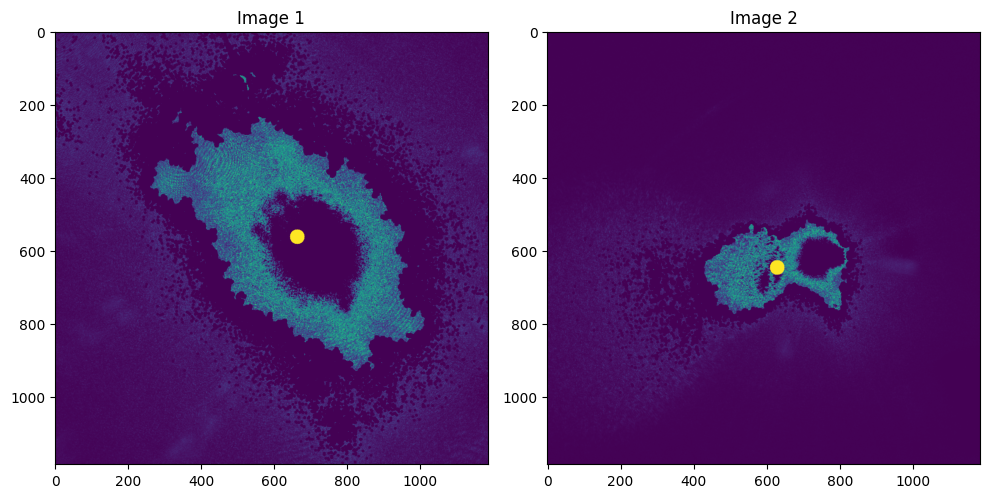

ORi, X: 662.0 Y: 562.0CAL, X: 629.0 Y: 646.0


In [60]:
BINS = 1
# Have both gain and exposure as None to allow auto calibration
GAIN = None
EXPOSURE = None #us
roi_dim = 1184
frames_for_dark = 10
buffer_size = 10

root_dir = os.path.dirname(os.getcwd())
camera = setup_camera(root_dir, 'libASICamera2.dylib', bins=BINS, gain= GAIN, exposure= EXPOSURE, roi_dim= roi_dim)
master_dark: np.ndarray = get_master_dark(camera, num_frames= frames_for_dark)

origin_frames = [get_redness_frame(get_clean_frame(camera.capture(), master_dark)) for _ in range(10)]
origin_image = np.median(origin_frames, axis = 0).astype(np.uint8)


o_contours = get_contours(origin_image)
o_largest_contour = get_largest_contour(o_contours)
origin_x, origin_y = get_contour_origin(o_largest_contour)

origin_image = origin_image.copy()
cv2.drawContours(
    image=origin_image,
    contours=o_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=origin_image,
    center=(int(origin_x), int(origin_y)),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

fsm_controller.send_command(f"control strategy on")
amplitude = 0.5
fsm_controller.send_command(f"signal generate -a y -w dc -A {amplitude}")


calibrate_frames = [get_redness_frame(get_clean_frame(camera.capture(), master_dark)) for _ in range(10)]
calibrate_image = np.median(calibrate_frames, axis = 0).astype(np.uint8)

fsm_controller.send_command(f"control strategy off")


c_contours = get_contours(calibrate_image)
c_largest_contour = get_largest_contour(c_contours)
calibrate_x, calibrate_y = get_contour_origin(c_largest_contour)

calibrate_image = calibrate_image.copy()
cv2.drawContours(
    image=calibrate_image,
    contours=c_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=calibrate_image,
    center=(int(calibrate_x), int(calibrate_y)),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

delta_x = abs(origin_x - calibrate_x)
delta_y = abs(origin_y - calibrate_y)

amplitude_per_pixel_x: float = amplitude / delta_x
amplitude_per_pixel_y: float = amplitude / delta_y

show_images(origin_image, calibrate_image)
print(f"ORi, X: {origin_x} Y: {origin_y}"
      f"CAL, X: {calibrate_x} Y: {calibrate_y}")
camera.close()

In [87]:
import os
import cv2
from src.camera.camera_setup import setup_camera


BINS = 4
# Have both gain and exposure as None to allow auto calibration
GAIN = 190
EXPOSURE = 25216  # µs
RESOLUTION = (8288, 5644)
START_POS = (0, 0)
FRAMES_DARK = 10
BUFFER_CAPACITY = 1
ITERATIONS: int = 300
COLOUR: bool = False
# Contour mode for finding center of brightest point, if false cv2.minMaxLox will be used
CONTOUR_MODE: bool = True

root_dir = os.path.dirname(os.getcwd())

# Setting up camera
camera = setup_camera(root_dir, 'libASICamera2.dylib', bins=BINS,
                      gain=GAIN, exposure=EXPOSURE, resolution= RESOLUTION,
                      start_pos= START_POS, colour=COLOUR)

TypeError: setup_camera() got an unexpected keyword argument 'resolution'

In [88]:
camera.close()

NameError: name 'camera' is not defined

In [ ]:
image = cv2.imread("/Users/Eric/PycharmProjects/satelite_tracking/resources/images/test_image.jpg")

_, mask = cv2.threshold(
    src=image,
    thresh=69,  # This value is ignored because Otsus method is used
    maxval=255,
    type=cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Use morphological opening to remove small noise blobs in the mask
kernel = np.ones((3, 3), np.uint8)
clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Find external contours in the binary mask
contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)